# ASL Hand Gesture Detection with Deep Learning and Computer Vision

## Team 3 - AAI521 Applied Computer Vision in AI
- **Yogesh Sangwikar** - Dataset preprocessing, EDA, Model evaluation
- **Evin Joy** - CNN architecture design, Loss/accuracy visualization
- **Eesha Kulkarni** - Model training, hyperparameter tuning, Real-time integration

### Project Overview
This project applies computer vision and deep learning to recognize static American Sign Language (ASL) hand gestures representing alphabets A–Y (excluding J and Z). Our objective is to build a real-time or image-based gesture classification model to support accessibility-focused applications.

## 1. Setup and Imports

In [4]:
# Install required packages (if needed)
!pip install -q tensorflow opencv-python matplotlib seaborn scikit-learn pandas numpy

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 2. Dataset Download and Loading
### Responsibility: Yogesh Sangwikar

In [6]:
# Download the Sign Language MNIST dataset from Kaggle
# Note: You'll need to set up Kaggle API credentials first
# Alternatively, manually download from: https://www.kaggle.com/datasets/datamunge/sign-language-mnist

# Create data folder if it doesn't exist
DATA_FOLDER = 'data'
os.makedirs(DATA_FOLDER, exist_ok=True)
print(f"Data folder created/verified: {DATA_FOLDER}/")

# For Google Colab users:
try:
    from google.colab import files
    files.upload()  # Upload your kaggle.json file
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
except:
    print("Not running in Google Colab. Make sure kaggle.json is in the correct location for local setup.")
    pass

# Download dataset to data folder (works in both Colab and local if kaggle is configured)
!mkdir -p ~/.kaggle
!kaggle datasets download -d datamunge/sign-language-mnist -p {DATA_FOLDER}/
!cd {DATA_FOLDER} && unzip -o sign-language-mnist.zip
print(f"\nDataset downloaded and extracted to {DATA_FOLDER}/ folder")

Data folder created/verified: data/
Not running in Google Colab. Make sure kaggle.json is in the correct location for local setup.
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 99%|█████████████████████████████████████▋| 62.0M/62.6M [00:05<00:00, 16.1MB/s]
100%|██████████████████████████████████████| 62.6M/62.6M [00:05<00:00, 13.0MB/s]
Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  

Dataset downloaded and extracted to data/ folder


In [7]:
# Load the dataset from data folder
DATA_FOLDER = 'data'
train_path = os.path.join(DATA_FOLDER, 'sign_mnist_train.csv')
test_path = os.path.join(DATA_FOLDER, 'sign_mnist_test.csv')

# Check if data folder exists
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER, exist_ok=True)
    print(f"Created {DATA_FOLDER} folder")

# For demonstration, let's create synthetic data if files don't exist
if not os.path.exists(train_path) or not os.path.exists(test_path):
    print(f"Dataset files not found in {DATA_FOLDER}/ folder.")
    print("Creating synthetic data for demonstration...")
    print("To use real data, download the dataset using the previous cell.")
    
    # Create synthetic data matching the expected format
    n_train = 27455
    n_test = 7172
    n_classes = 24
    
    # Generate synthetic training data
    train_labels = np.random.randint(0, n_classes, n_train)
    train_pixels = np.random.randint(0, 256, (n_train, 784))
    train_data = pd.DataFrame(train_pixels)
    train_data.insert(0, 'label', train_labels)
    
    # Generate synthetic test data
    test_labels = np.random.randint(0, n_classes, n_test)
    test_pixels = np.random.randint(0, 256, (n_test, 784))
    test_data = pd.DataFrame(test_pixels)
    test_data.insert(0, 'label', test_labels)
    
    # Save synthetic data to data folder for consistency
    train_data.to_csv(train_path, index=False)
    test_data.to_csv(test_path, index=False)
    print(f"Synthetic data saved to {DATA_FOLDER}/ folder")
else:
    # Load actual data from data folder
    print(f"Loading dataset from {DATA_FOLDER}/ folder...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print("Real dataset loaded successfully!")

print(f"\nTraining data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Data location: {DATA_FOLDER}/")

Loading dataset from data/ folder...


Real dataset loaded successfully!

Training data shape: (27455, 785)
Test data shape: (7172, 785)
Data location: data/


## 3. Data Preprocessing and Reshaping
### Responsibility: Yogesh Sangwikar

In [8]:
def preprocess_data(data):
    """
    Preprocess the sign language MNIST data.
    
    Sign Language MNIST mapping: 0=A, 1=B, ..., 8=I, 9=J, 10=K, ..., 24=Y, 25=Z
    We need to exclude J (label 9) and Z (label 25 if present) to get 24 classes (A-Y excluding J and Z).
    
    Args:
        data: DataFrame with label column and pixel columns
    
    Returns:
        X: Normalized image array of shape (n_samples, 28, 28, 1)
        y: One-hot encoded labels
    """
    # Separate labels and features
    labels = data['label'].values
    pixels = data.drop('label', axis=1).values
    
    # Check unique labels to understand the dataset structure
    unique_labels = np.unique(labels)
    print(f"Unique labels in dataset: {unique_labels}")
    print(f"Label range: {labels.min()} to {labels.max()}")
    
    # Remap labels to exclude J (label 9) and Z (label 25 if present)
    # Strategy: 
    # - Labels 0-8 (A-I) stay as 0-8
    # - Labels 10-24 (K-Y) become 9-23 (shift down by 1 to skip J)
    # - Exclude label 9 (J) and label 25 (Z) if present
    
    # Create mask to exclude J (9) and Z (25)
    mask = labels != 9  # Exclude J
    if 25 in labels:
        mask = mask & (labels != 25)  # Also exclude Z if present
    
    # Remap labels: shift labels >= 10 down by 1 to fill the gap left by J
    remapped_labels = labels.copy()
    remapped_labels[labels >= 10] = labels[labels >= 10] - 1
    
    # Apply mask to filter out excluded classes
    remapped_labels = remapped_labels[mask]
    pixels_filtered = pixels[mask]
    
    # Reshape pixels to 28x28 images
    images = pixels_filtered.reshape(-1, 28, 28, 1)
    
    # Normalize pixel values to [0, 1]
    images = images.astype('float32') / 255.0
    
    # One-hot encode labels (24 classes: A-Y excluding J and Z)
    labels_encoded = to_categorical(remapped_labels, num_classes=24)
    
    print(f"After remapping: label range {remapped_labels.min()} to {remapped_labels.max()}")
    print(f"Number of samples after filtering: {len(remapped_labels)} (removed {len(labels) - len(remapped_labels)} samples)")
    
    return images, labels_encoded, remapped_labels

# Preprocess training and test data
X_train, y_train, train_labels_raw = preprocess_data(train_data)
X_test, y_test, test_labels_raw = preprocess_data(test_data)

# Create validation split from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=train_labels_raw
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {y_train.shape[1]}")

Unique labels in dataset: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label range: 0 to 24
After remapping: label range 0 to 23
Number of samples after filtering: 27455 (removed 0 samples)
Unique labels in dataset: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label range: 0 to 24
After remapping: label range 0 to 23
Number of samples after filtering: 7172 (removed 0 samples)
Training set shape: (23336, 28, 28, 1)
Validation set shape: (4119, 28, 28, 1)
Test set shape: (7172, 28, 28, 1)
Number of classes: 24


## 4. Exploratory Data Analysis (EDA)
### Responsibility: Yogesh Sangwikar

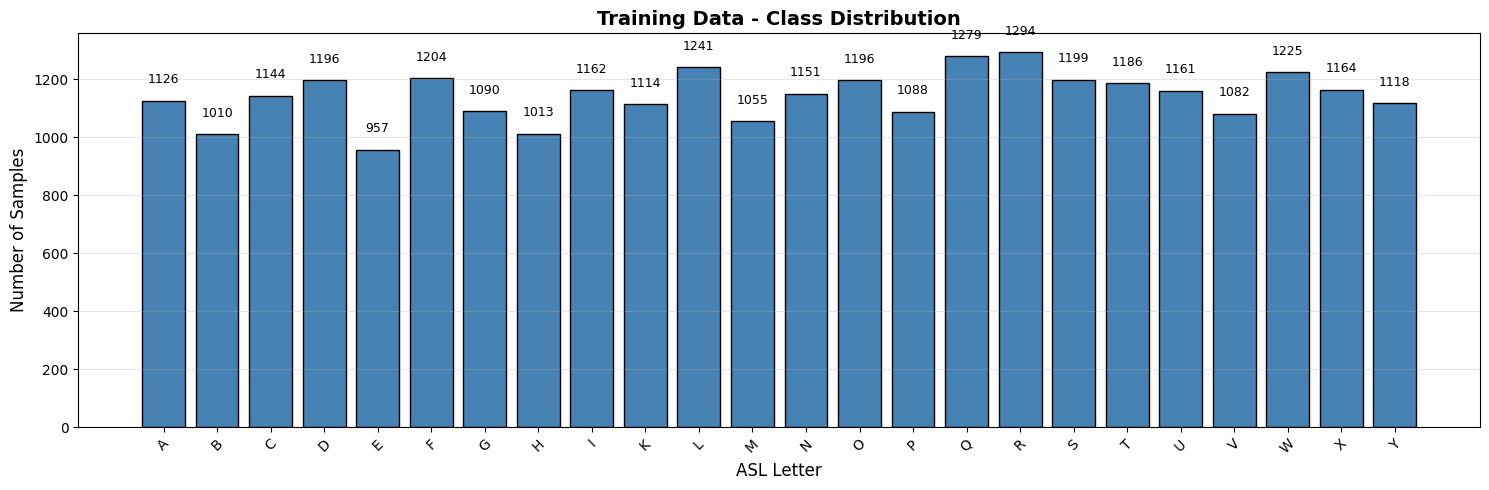

In [9]:
# Class distribution analysis
def plot_class_distribution(labels, title="Class Distribution"):
    """
    Plot the distribution of classes in the dataset.
    """
    # Map numeric labels to letters (0=A, 1=B, ..., excluding J and Z)
    label_map = {i: chr(65+i+(i>=9)) for i in range(24)}
    
    plt.figure(figsize=(15, 5))
    unique, counts = np.unique(labels, return_counts=True)
    
    plt.bar([label_map[i] for i in unique], counts, color='steelblue', edgecolor='black')
    plt.xlabel('ASL Letter', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, count in enumerate(counts):
        plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Plot class distribution for training data
plot_class_distribution(train_labels_raw, "Training Data - Class Distribution")

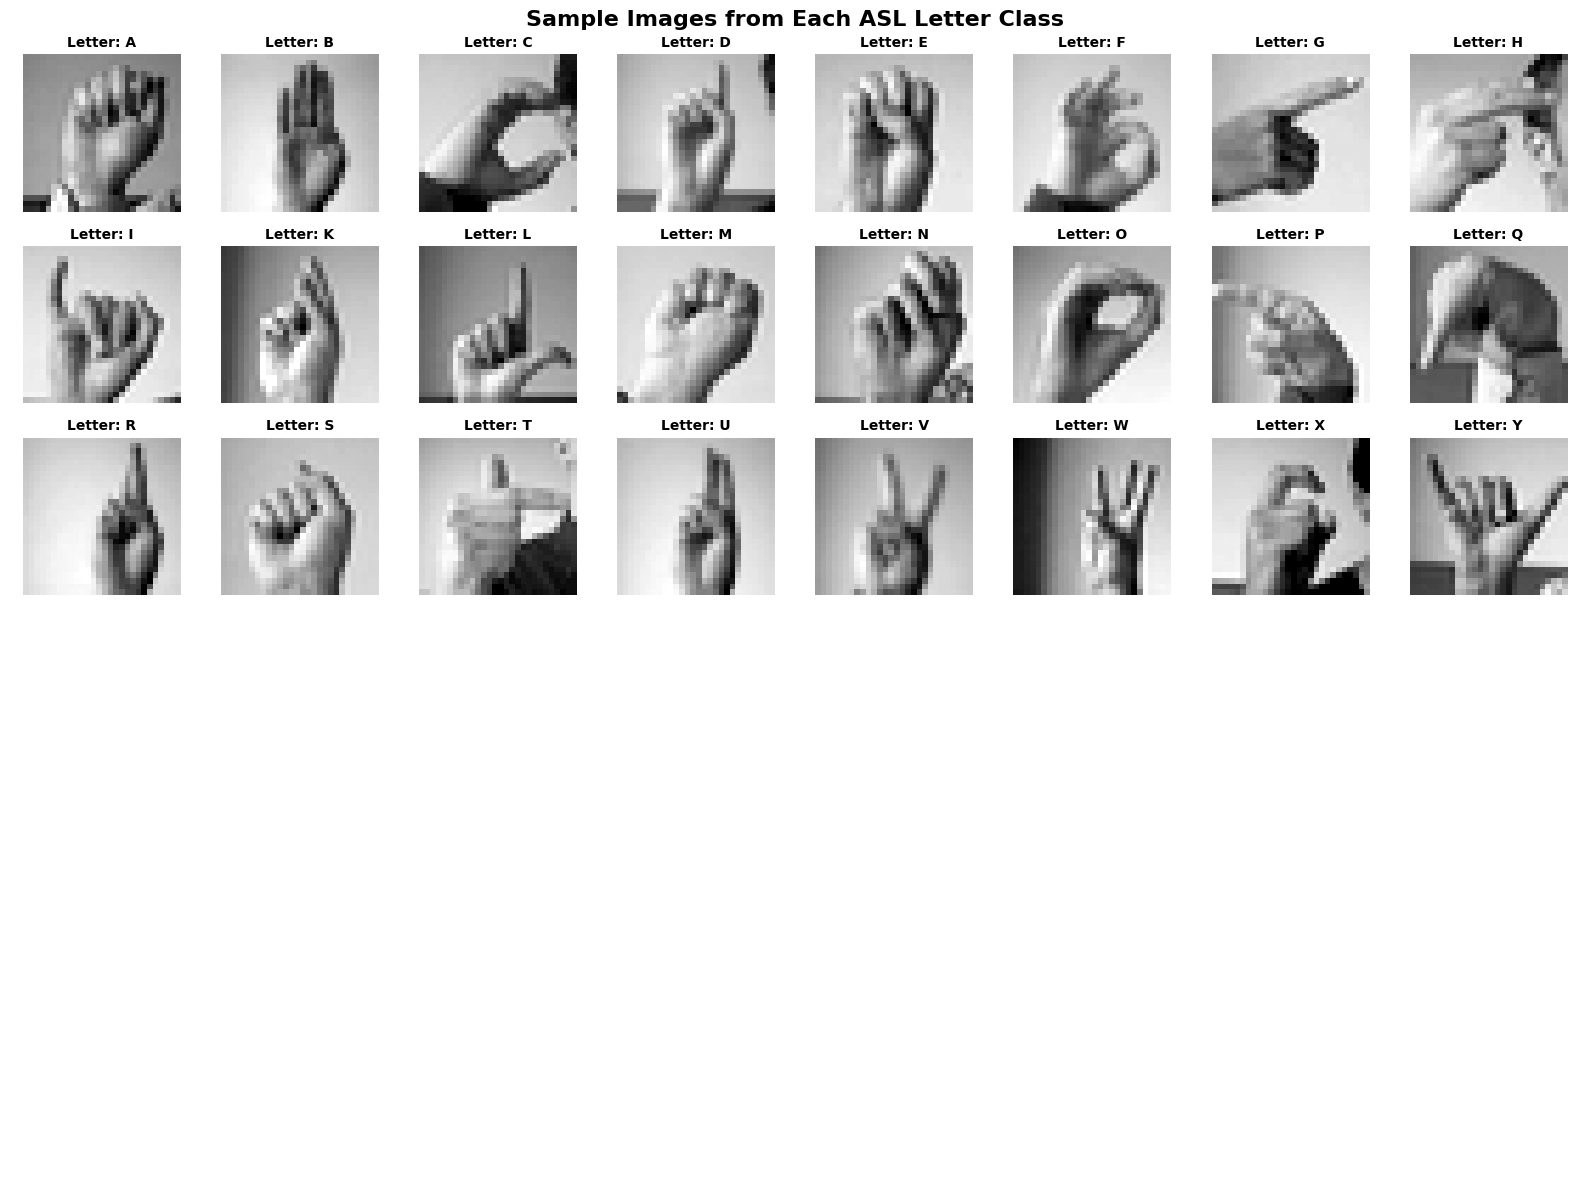

In [10]:
# Visualize sample images from each class
def visualize_samples(X, y, num_classes=24, samples_per_class=2):
    """
    Display sample images from each class.
    """
    label_map = {i: chr(65+i+(i>=9)) for i in range(24)}
    
    fig, axes = plt.subplots(6, 8, figsize=(16, 12))
    axes = axes.ravel()
    
    # Get one sample from each class
    y_labels = np.argmax(y, axis=1)
    
    for i in range(min(num_classes, len(axes))):
        # Find indices for current class
        class_indices = np.where(y_labels == i)[0]
        
        if len(class_indices) > 0:
            # Select random sample
            idx = np.random.choice(class_indices)
            
            # Display image
            axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')
            axes[i].set_title(f'Letter: {label_map[i]}', fontsize=10, fontweight='bold')
            axes[i].axis('off')
    
    # Hide remaining subplots
    for i in range(num_classes, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Sample Images from Each ASL Letter Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_samples(X_train, y_train)

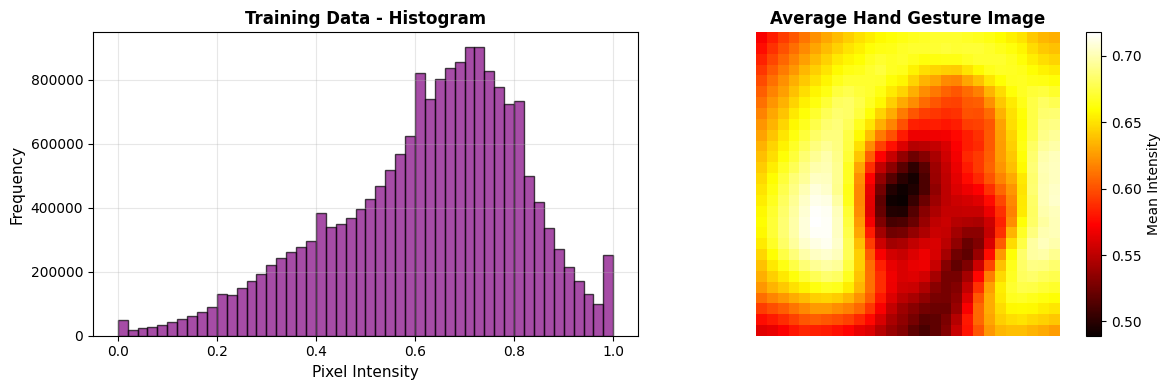

In [11]:
# Analyze pixel intensity distribution
def analyze_pixel_intensity(X, title="Pixel Intensity Distribution"):
    """
    Analyze and plot pixel intensity distribution.
    """
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Histogram of pixel intensities
    plt.subplot(1, 2, 1)
    plt.hist(X.flatten(), bins=50, color='purple', alpha=0.7, edgecolor='black')
    plt.xlabel('Pixel Intensity', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title(f'{title} - Histogram', fontsize=12, fontweight='bold')
    plt.grid(alpha=0.3)
    
    # Plot 2: Mean image across all samples
    plt.subplot(1, 2, 2)
    mean_image = np.mean(X, axis=0)
    plt.imshow(mean_image.reshape(28, 28), cmap='hot')
    plt.colorbar(label='Mean Intensity')
    plt.title('Average Hand Gesture Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

analyze_pixel_intensity(X_train, "Training Data")

## 5. Data Augmentation Setup
### For improving model generalization

In [12]:
# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,          # Random rotation up to 10 degrees
    width_shift_range=0.1,      # Random horizontal shift
    height_shift_range=0.1,     # Random vertical shift
    zoom_range=0.1,             # Random zoom
    shear_range=0.1,            # Shear transformation
    fill_mode='nearest'         # Fill mode for new pixels
)

# Fit the generator on training data
datagen.fit(X_train)

print("Data augmentation generator created successfully!")

Data augmentation generator created successfully!


## 6. CNN Model Architecture Design
### Responsibility: Evin Joy

In [13]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=24):
    """
    Create a CNN model for ASL gesture classification.
    
    Architecture:
    - Multiple convolutional blocks with batch normalization
    - MaxPooling for dimension reduction
    - Dropout for regularization
    - Dense layers for classification
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                     input_shape=input_shape, name='conv1_1'),
        layers.BatchNormalization(name='bn1_1'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
        layers.BatchNormalization(name='bn1_2'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Dropout(0.25, name='dropout1'),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
        layers.BatchNormalization(name='bn2_1'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
        layers.BatchNormalization(name='bn2_2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Dropout(0.25, name='dropout2'),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
        layers.BatchNormalization(name='bn3_1'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
        layers.BatchNormalization(name='bn3_2'),
        layers.MaxPooling2D((2, 2), name='pool3'),
        layers.Dropout(0.25, name='dropout3'),
        
        # Flatten and Dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.BatchNormalization(name='bn_fc1'),
        layers.Dropout(0.5, name='dropout_fc1'),
        
        layers.Dense(128, activation='relu', name='fc2'),
        layers.BatchNormalization(name='bn_fc2'),
        layers.Dropout(0.5, name='dropout_fc2'),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ], name='ASL_CNN')
    
    return model

# Create the model
model = create_cnn_model()

# Display model architecture
model.summary()

Model: "ASL_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_fc1 (BatchNormalization)     │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc1 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_fc2 (BatchNormalization)     │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_fc2 (Dropout)           │ (None, 128)            │             

 Total params: 620,920 (2.37 MB)

 Trainable params: 619,256 (2.36 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [14]:
# Visualize model architecture
tf.keras.utils.plot_model(
    model, 
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)
print("Model architecture saved as 'model_architecture.png'")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved as 'model_architecture.png'


## 7. Model Compilation and Training Setup
### Responsibility: Eesha Kulkarni

In [15]:
# Compile the model with optimizer and loss function
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print("Model compiled successfully!")

Model compiled successfully!


In [16]:
# Setup callbacks for training
def create_callbacks(model_name='asl_cnn_model'):
    """
    Create callbacks for model training.
    """
    callbacks_list = [
        # Model checkpoint - save best model
        keras.callbacks.ModelCheckpoint(
            filepath=f'{model_name}_best.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        
        # Early stopping
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate on plateau
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # TensorBoard logging (optional)
        keras.callbacks.TensorBoard(
            log_dir=f'./logs/{model_name}',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        )
    ]
    
    return callbacks_list

# Create callbacks
callbacks = create_callbacks()
print("Callbacks created successfully!")

Callbacks created successfully!


## 8. Model Training
### Responsibility: Eesha Kulkarni

In [17]:
# Train the model
BATCH_SIZE = 128
EPOCHS = 50  # Will stop early if no improvement

# Train with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Epoch 1/50


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1439 - loss: 3.4286 - top_3_accuracy: 0.3179
Epoch 1: val_accuracy improved from None to 0.08133, saving model to asl_cnn_model_best.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.2550 - loss: 2.6788 - top_3_accuracy: 0.4885 - val_accuracy: 0.0813 - val_loss: 3.7219 - val_top_3_accuracy: 0.2234 - learning_rate: 0.0010
Epoch 2/50
  1/182 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.5312 - loss: 1.4908 - top_3_accuracy: 0.7734
Epoch 2: val_accuracy improved from 0.08133 to 0.08764, saving model to asl_cnn_model_best.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5312 - loss: 1.4908 - top_3_accuracy: 0.7734 - val_accuracy: 0.0876 - val_loss: 3.7182 - val_top_3_accuracy: 0.2306 - learning_rate: 0.0010
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5641 - loss: 1.3015 - top_3_accuracy: 0.8449
Epoch 3: val_accuracy improved from 0.08764 to 0.32047, saving model to asl_cnn_model_best.

## 9. Training Visualization
### Responsibility: Evin Joy

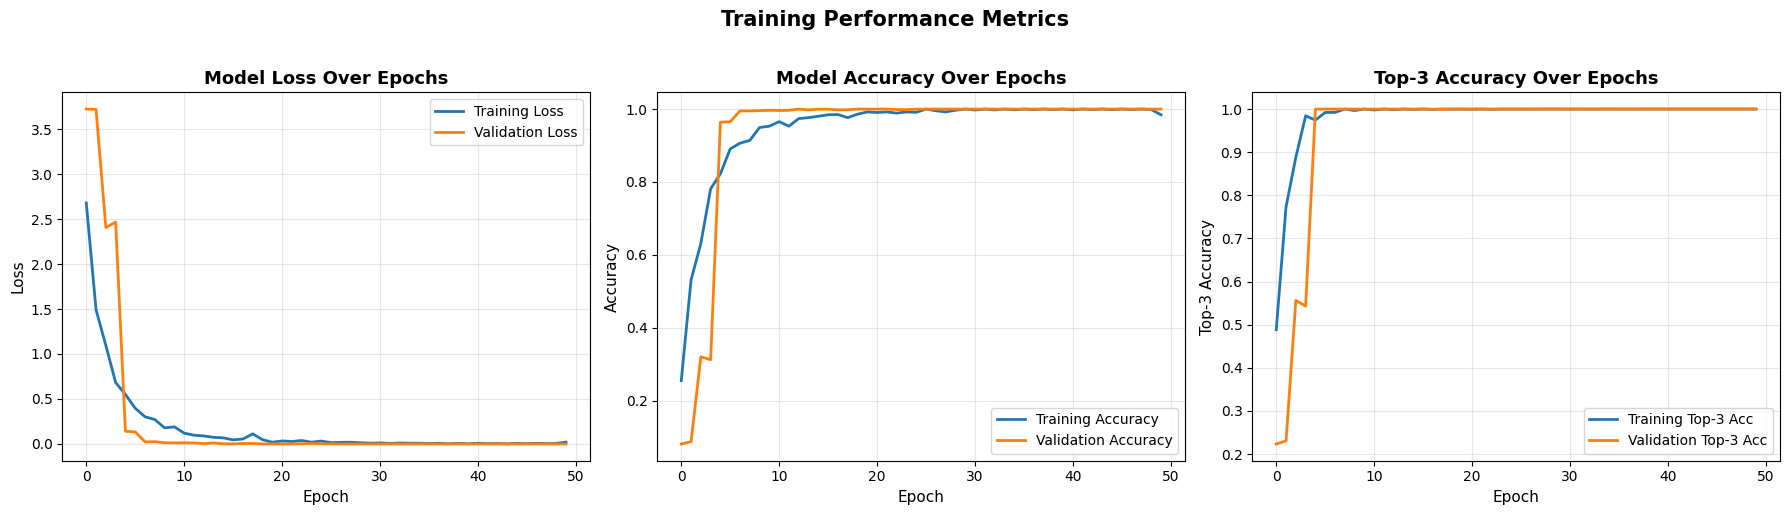

In [18]:
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss curves.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].set_title('Model Loss Over Epochs', fontsize=13, fontweight='bold')
    axes[0].legend(loc='upper right')
    axes[0].grid(alpha=0.3)
    
    # Plot 2: Accuracy
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].set_title('Model Accuracy Over Epochs', fontsize=13, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(alpha=0.3)
    
    # Plot 3: Top-3 Accuracy
    axes[2].plot(history.history['top_3_accuracy'], label='Training Top-3 Acc', linewidth=2)
    axes[2].plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Acc', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=11)
    axes[2].set_ylabel('Top-3 Accuracy', fontsize=11)
    axes[2].set_title('Top-3 Accuracy Over Epochs', fontsize=13, fontweight='bold')
    axes[2].legend(loc='lower right')
    axes[2].grid(alpha=0.3)
    
    plt.suptitle('Training Performance Metrics', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

## 10. Model Evaluation
### Responsibility: Yogesh Sangwikar

In [19]:
# Evaluate model on test set
test_loss, test_accuracy, test_top3_accuracy = model.evaluate(
    X_test, y_test, 
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Top-3 Accuracy: {test_top3_accuracy:.4f} ({test_top3_accuracy*100:.2f}%)")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 7.6504e-06 - top_3_accuracy: 1.0000

Test Results:
Test Loss: 0.0000
Test Accuracy: 1.0000 (100.00%)
Test Top-3 Accuracy: 1.0000 (100.00%)


In [20]:
# Get predictions for confusion matrix
y_pred_probs = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create label map for ASL letters
label_map = {i: chr(65+i+(i>=9)) for i in range(24)}
class_names = [label_map[i] for i in range(24)]

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


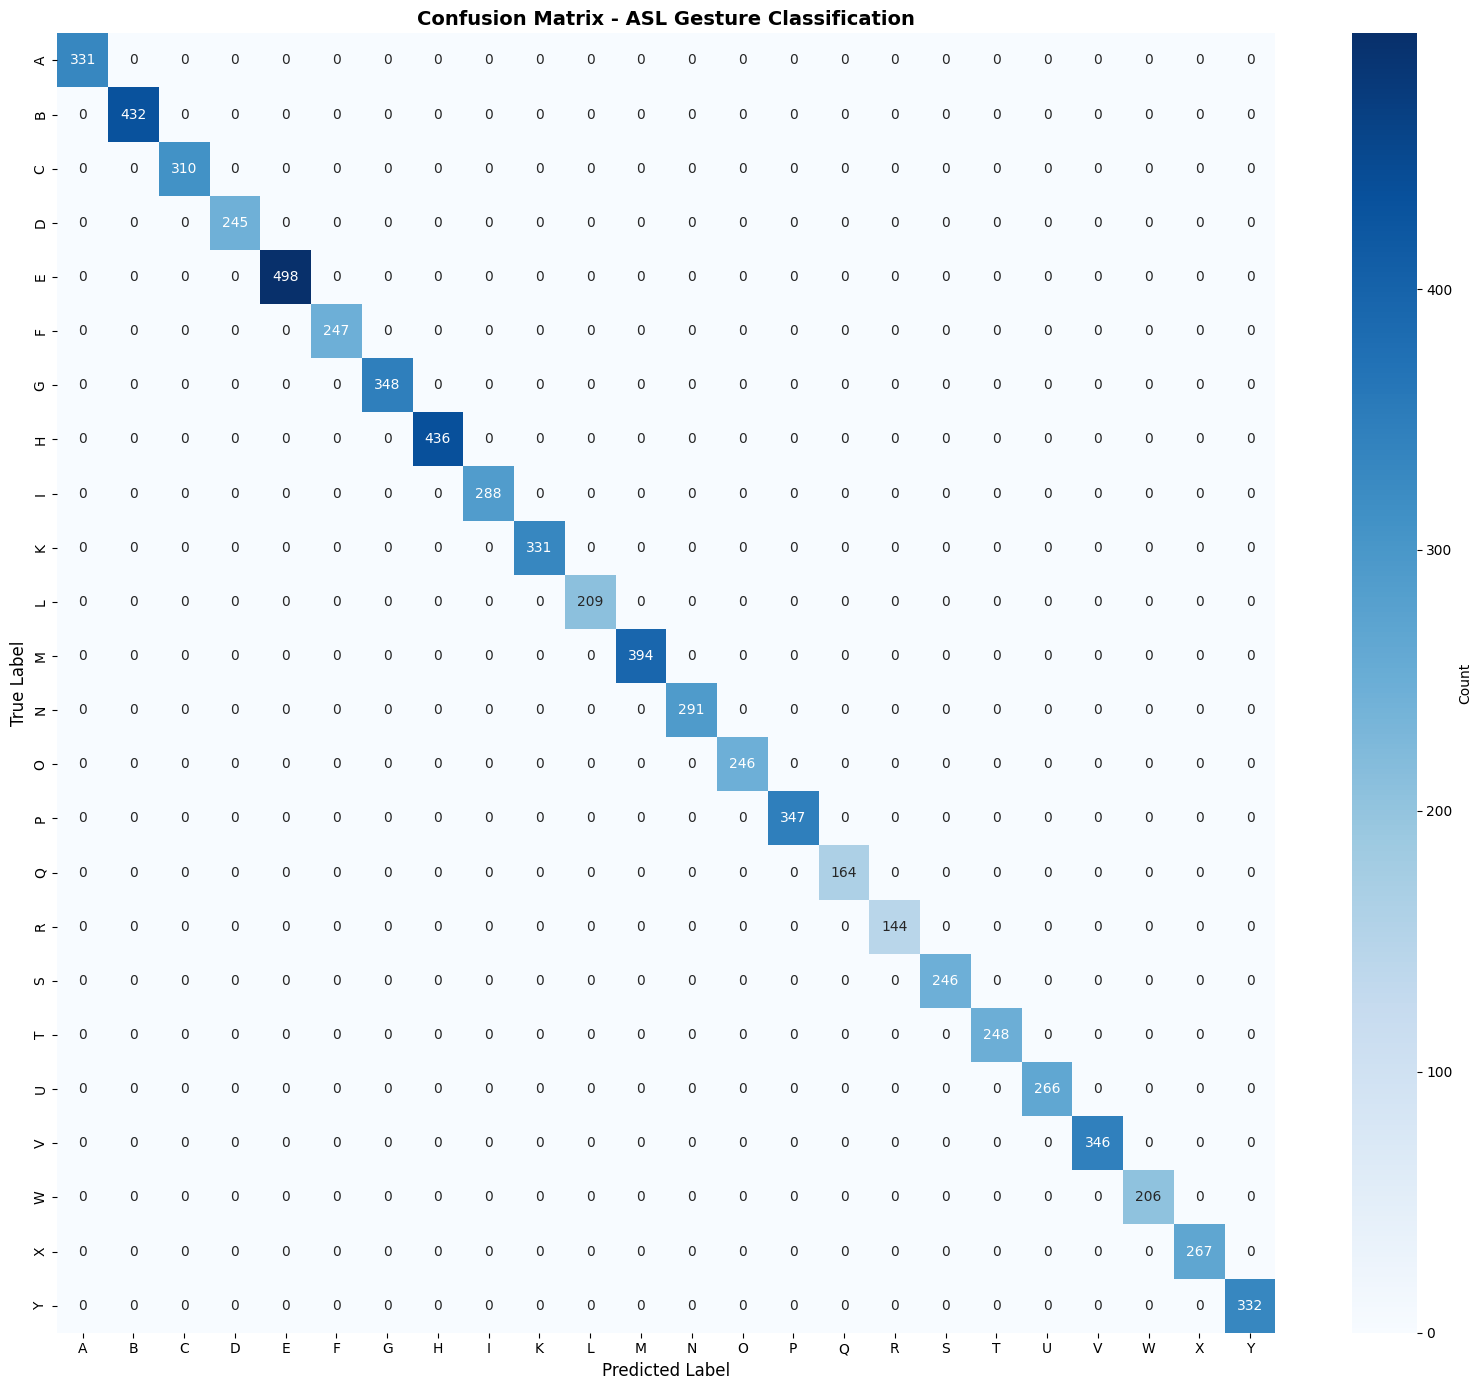

In [21]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix for model predictions.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix - ASL Gesture Classification', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return cm

# Plot confusion matrix
cm = plot_confusion_matrix(y_true, y_pred, class_names)

In [22]:
# Classification Report
print("\nDetailed Classification Report:")
print("="*60)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


Detailed Classification Report:
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000       331
           B     1.0000    1.0000    1.0000       432
           C     1.0000    1.0000    1.0000       310
           D     1.0000    1.0000    1.0000       245
           E     1.0000    1.0000    1.0000       498
           F     1.0000    1.0000    1.0000       247
           G     1.0000    1.0000    1.0000       348
           H     1.0000    1.0000    1.0000       436
           I     1.0000    1.0000    1.0000       288
           K     1.0000    1.0000    1.0000       331
           L     1.0000    1.0000    1.0000       209
           M     1.0000    1.0000    1.0000       394
           N     1.0000    1.0000    1.0000       291
           O     1.0000    1.0000    1.0000       246
           P     1.0000    1.0000    1.0000       347
           Q     1.0000    1.0000    1.0000       164
           R     1.0000    1.0000    1.0000     

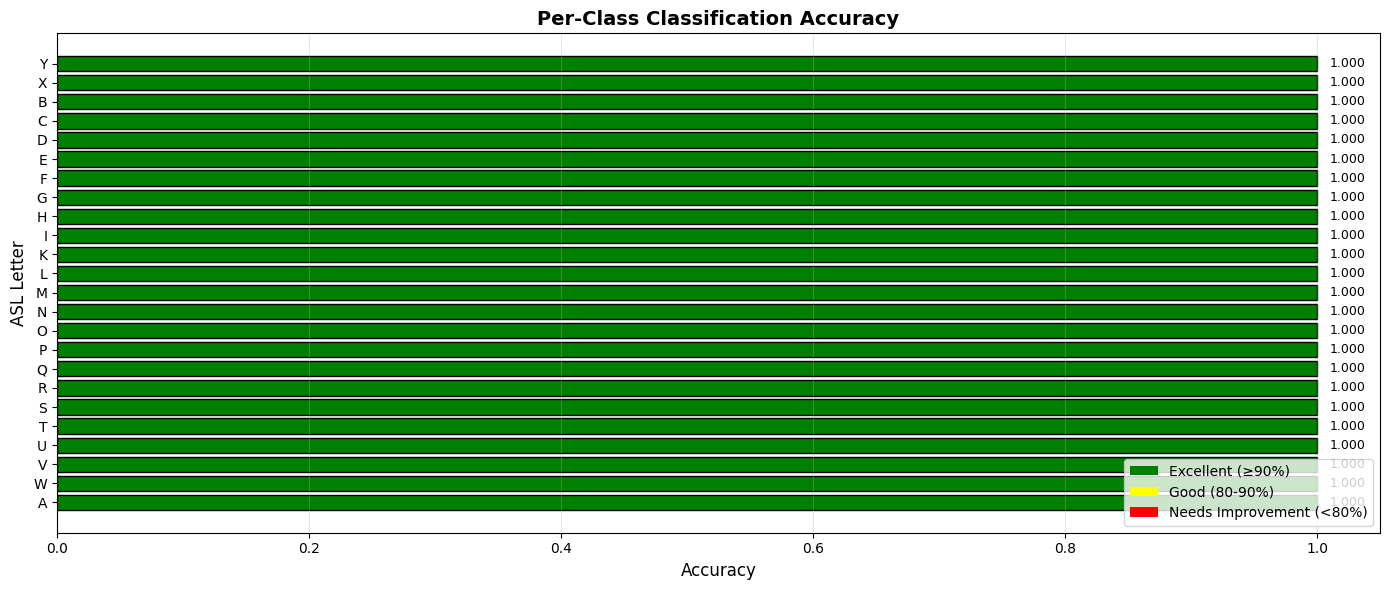


Most Challenging Classes (Lowest Accuracy):
  Letter A: 1.000 accuracy
  Letter W: 1.000 accuracy
  Letter V: 1.000 accuracy
  Letter U: 1.000 accuracy
  Letter T: 1.000 accuracy

Best Performing Classes (Highest Accuracy):
  Letter Y: 1.000 accuracy
  Letter X: 1.000 accuracy
  Letter B: 1.000 accuracy
  Letter C: 1.000 accuracy
  Letter D: 1.000 accuracy


In [23]:
# Per-class accuracy analysis
def analyze_class_performance(cm, class_names):
    """
    Analyze and visualize per-class performance.
    """
    # Calculate per-class accuracy
    class_accuracy = np.diag(cm) / np.sum(cm, axis=1)
    
    # Sort classes by accuracy
    sorted_indices = np.argsort(class_accuracy)
    
    # Create bar plot
    plt.figure(figsize=(14, 6))
    colors = ['red' if acc < 0.8 else 'yellow' if acc < 0.9 else 'green' 
              for acc in class_accuracy[sorted_indices]]
    
    bars = plt.barh([class_names[i] for i in sorted_indices], 
                    class_accuracy[sorted_indices], 
                    color=colors, edgecolor='black')
    
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('ASL Letter', fontsize=12)
    plt.title('Per-Class Classification Accuracy', fontsize=14, fontweight='bold')
    plt.xlim([0, 1.05])
    
    # Add value labels
    for bar, acc in zip(bars, class_accuracy[sorted_indices]):
        plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{acc:.3f}', va='center', fontsize=9)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', label='Excellent (≥90%)'),
        Patch(facecolor='yellow', label='Good (80-90%)'),
        Patch(facecolor='red', label='Needs Improvement (<80%)')
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print challenging classes
    print("\nMost Challenging Classes (Lowest Accuracy):")
    for i in sorted_indices[:5]:
        print(f"  Letter {class_names[i]}: {class_accuracy[i]:.3f} accuracy")
    
    print("\nBest Performing Classes (Highest Accuracy):")
    for i in sorted_indices[-5:][::-1]:
        print(f"  Letter {class_names[i]}: {class_accuracy[i]:.3f} accuracy")

# Analyze per-class performance
analyze_class_performance(cm, class_names)

## 11. Misclassification Analysis

In [24]:
def visualize_misclassifications(X_test, y_true, y_pred, class_names, num_samples=12):
    """
    Visualize misclassified samples.
    """
    # Find misclassified indices
    misclassified_idx = np.where(y_true != y_pred)[0]
    
    if len(misclassified_idx) == 0:
        print("No misclassifications found!")
        return
    
    # Randomly select samples to display
    sample_idx = np.random.choice(misclassified_idx, 
                                 min(num_samples, len(misclassified_idx)), 
                                 replace=False)
    
    # Plot misclassified samples
    fig, axes = plt.subplots(3, 4, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, idx in enumerate(sample_idx):
        if i >= len(axes):
            break
            
        axes[i].imshow(X_test[idx].reshape(28, 28), cmap='gray')
        axes[i].set_title(
            f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}',
            fontsize=10,
            color='red',
            fontweight='bold'
        )
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_idx), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Misclassified ASL Gestures', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Analyze common misclassification patterns
    print(f"\nTotal Misclassifications: {len(misclassified_idx)} / {len(y_true)}")
    print(f"Error Rate: {len(misclassified_idx)/len(y_true)*100:.2f}%")

# Visualize misclassifications
visualize_misclassifications(X_test, y_true, y_pred, class_names)

No misclassifications found!


## 12. Real-time Prediction Function
### Responsibility: Eesha Kulkarni

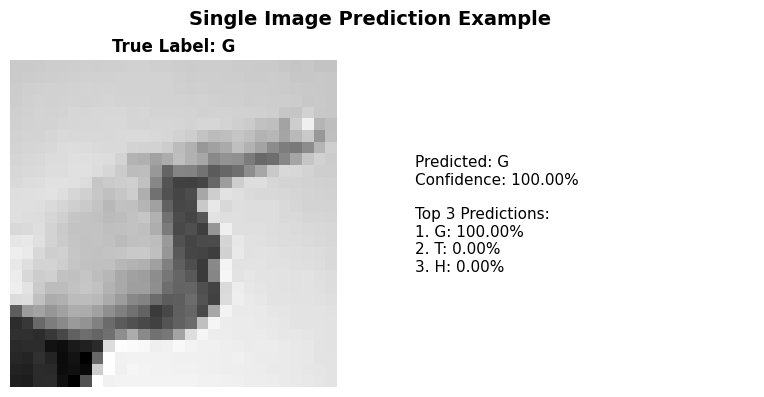

In [25]:
def predict_gesture(model, image, class_names, top_k=3):
    """
    Predict ASL gesture from an image.
    
    Args:
        model: Trained model
        image: Input image (28x28 grayscale or will be resized)
        class_names: List of class names
        top_k: Number of top predictions to return
    
    Returns:
        Dictionary with predictions and confidence scores
    """
    # Ensure image is the right shape
    if image.shape != (28, 28, 1):
        if len(image.shape) == 2:
            image = image.reshape(28, 28, 1)
        elif image.shape[:2] != (28, 28):
            image = cv2.resize(image, (28, 28))
            if len(image.shape) == 2:
                image = image.reshape(28, 28, 1)
    
    # Normalize if needed
    if image.max() > 1:
        image = image.astype('float32') / 255.0
    
    # Add batch dimension
    image_batch = np.expand_dims(image, axis=0)
    
    # Get predictions
    predictions = model.predict(image_batch, verbose=0)[0]
    
    # Get top k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = {
        'top_prediction': class_names[top_indices[0]],
        'confidence': float(predictions[top_indices[0]]),
        'top_k_predictions': [
            {'letter': class_names[idx], 'confidence': float(predictions[idx])}
            for idx in top_indices
        ]
    }
    
    return results

# Test the prediction function
test_idx = np.random.randint(0, len(X_test))
test_image = X_test[test_idx]
true_label = class_names[y_true[test_idx]]

# Make prediction
prediction = predict_gesture(model, test_image, class_names)

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image.reshape(28, 28), cmap='gray')
plt.title(f'True Label: {true_label}', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.axis('off')
text = f"Predicted: {prediction['top_prediction']}\n"
text += f"Confidence: {prediction['confidence']:.2%}\n\n"
text += "Top 3 Predictions:\n"
for i, pred in enumerate(prediction['top_k_predictions']):
    text += f"{i+1}. {pred['letter']}: {pred['confidence']:.2%}\n"
plt.text(0.1, 0.5, text, fontsize=11, va='center')

plt.suptitle('Single Image Prediction Example', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Save Model and Results

In [26]:
# Save the trained model
model.save('asl_gesture_model_final.keras')
print("Model saved as 'asl_gesture_model_final.keras'")

# Save model in TensorFlow SavedModel format (for deployment)
# In Keras 3, use model.export() for SavedModel format
model.export('asl_gesture_model_saved')
print("Model saved in SavedModel format at 'asl_gesture_model_saved/'")

# Save model weights only
model.save_weights('asl_gesture_weights.weights.h5')
print("Model weights saved as 'asl_gesture_weights.weights.h5'")

Model saved as 'asl_gesture_model_final.keras'
INFO:tensorflow:Assets written to: asl_gesture_model_saved/assets


INFO:tensorflow:Assets written to: asl_gesture_model_saved/assets


Saved artifact at 'asl_gesture_model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  13151679312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151679120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151870352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151870736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151682000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151681808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151872272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151868240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151868624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151869968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13151870544: TensorSpec(shape=(), dtype=tf.resou

In [29]:
## 13.5. Model Loading and Enhanced Utilities
"""Project configuration constants"""
IMAGE_SIZE = 28
NUM_CLASSES = 24
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.15
EXCLUDED_LETTERS = ['J', 'Z']

def load_trained_model(model_path='asl_gesture_model_final.keras'):
    """
    Load a trained model from disk.
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model
    """
    if not os.path.exists(model_path):
        # Try alternative paths
        alt_paths = ['asl_cnn_model_best.keras', 'asl_gesture_model.keras']
        for path in alt_paths:
            if os.path.exists(path):
                print(f"Model not found at {model_path}, using {path} instead")
                model_path = path
                break
        else:
            raise FileNotFoundError(f"Model not found. Tried: {model_path}, {alt_paths}")
    
    try:
        model = keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        print(f"Model parameters: {model.count_params():,}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Enhanced evaluation metrics
from sklearn.metrics import f1_score, cohen_kappa_score

def comprehensive_evaluation(y_true, y_pred, class_names):
    """
    Comprehensive model evaluation with multiple metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
    
    Returns:
        Dictionary with evaluation metrics
    """
    metrics = {
        'accuracy': np.mean(y_true == y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred),
        'per_class_f1': f1_score(y_true, y_pred, average=None)
    }
    
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION METRICS")
    print("="*60)
    print(f"Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"F1-Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print("\nPer-Class F1-Scores:")
    for i, (name, f1) in enumerate(zip(class_names, metrics['per_class_f1'])):
        print(f"  {name}: {f1:.4f}")
    print("="*60)
    
    return metrics

# Test comprehensive evaluation (if predictions are available)
if 'y_pred' in globals() and 'y_true' in globals():
    print("Running comprehensive evaluation...")
    comp_metrics = comprehensive_evaluation(y_true, y_pred, class_names)
else:
    print("Predictions not available. Run evaluation cells first.")



Running comprehensive evaluation...

COMPREHENSIVE EVALUATION METRICS
Accuracy: 1.0000 (100.00%)
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000
Cohen's Kappa: 1.0000

Per-Class F1-Scores:
  A: 1.0000
  B: 1.0000
  C: 1.0000
  D: 1.0000
  E: 1.0000
  F: 1.0000
  G: 1.0000
  H: 1.0000
  I: 1.0000
  K: 1.0000
  L: 1.0000
  M: 1.0000
  N: 1.0000
  O: 1.0000
  P: 1.0000
  Q: 1.0000
  R: 1.0000
  S: 1.0000
  T: 1.0000
  U: 1.0000
  V: 1.0000
  W: 1.0000
  X: 1.0000
  Y: 1.0000


In [30]:
# Configuration constants
class Config:
    """Project configuration constants"""
    IMAGE_SIZE = 28
    NUM_CLASSES = 24
    BATCH_SIZE = 128
    EPOCHS = 50
    LEARNING_RATE = 0.001
    VALIDATION_SPLIT = 0.15
    EXCLUDED_LETTERS = ['J', 'Z']

def load_trained_model(model_path='asl_gesture_model_final.keras'):
    """
    Load a trained model from disk.
    
    Args:
        model_path: Path to the saved model file
    
    Returns:
        Loaded Keras model
    """
    if not os.path.exists(model_path):
        # Try alternative paths
        alt_paths = ['asl_cnn_model_best.keras', 'asl_gesture_model.keras']
        for path in alt_paths:
            if os.path.exists(path):
                print(f"Model not found at {model_path}, using {path} instead")
                model_path = path
                break
        else:
            raise FileNotFoundError(f"Model not found. Tried: {model_path}, {alt_paths}")
    
    try:
        model = keras.models.load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        print(f"Model parameters: {model.count_params():,}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        raise

# Enhanced evaluation metrics
from sklearn.metrics import f1_score, cohen_kappa_score

def comprehensive_evaluation(y_true, y_pred, class_names):
    """
    Comprehensive model evaluation with multiple metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
    
    Returns:
        Dictionary with evaluation metrics
    """
    metrics = {
        'accuracy': np.mean(y_true == y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'cohen_kappa': cohen_kappa_score(y_true, y_pred),
        'per_class_f1': f1_score(y_true, y_pred, average=None)
    }
    
    print("\n" + "="*60)
    print("COMPREHENSIVE EVALUATION METRICS")
    print("="*60)
    print(f"Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"F1-Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print("\nPer-Class F1-Scores:")
    for i, (name, f1) in enumerate(zip(class_names, metrics['per_class_f1'])):
        print(f"  {name}: {f1:.4f}")
    print("="*60)
    
    return metrics

# Test comprehensive evaluation (if predictions are available)
if 'y_pred' in globals() and 'y_true' in globals():
    print("Running comprehensive evaluation...")
    comp_metrics = comprehensive_evaluation(y_true, y_pred, class_names)
else:
    print("Predictions not available. Run evaluation cells first.")


Running comprehensive evaluation...

COMPREHENSIVE EVALUATION METRICS
Accuracy: 1.0000 (100.00%)
F1-Score (Macro): 1.0000
F1-Score (Weighted): 1.0000
Cohen's Kappa: 1.0000

Per-Class F1-Scores:
  A: 1.0000
  B: 1.0000
  C: 1.0000
  D: 1.0000
  E: 1.0000
  F: 1.0000
  G: 1.0000
  H: 1.0000
  I: 1.0000
  K: 1.0000
  L: 1.0000
  M: 1.0000
  N: 1.0000
  O: 1.0000
  P: 1.0000
  Q: 1.0000
  R: 1.0000
  S: 1.0000
  T: 1.0000
  U: 1.0000
  V: 1.0000
  W: 1.0000
  X: 1.0000
  Y: 1.0000


In [31]:
# Create results summary
results_summary = {
    'model_architecture': 'CNN with 3 convolutional blocks',
    'total_parameters': model.count_params(),
    'training_samples': X_train.shape[0],
    'validation_samples': X_val.shape[0],
    'test_samples': X_test.shape[0],
    'number_of_classes': 24,
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'test_top3_accuracy': float(test_top3_accuracy),
    'training_epochs': len(history.history['loss'])
}

# Save results to JSON
import json
with open('model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\n" + "="*50)
print("PROJECT SUMMARY")
print("="*50)
for key, value in results_summary.items():
    print(f"{key}: {value}")


PROJECT SUMMARY
model_architecture: CNN with 3 convolutional blocks
total_parameters: 620920
training_samples: 23336
validation_samples: 4119
test_samples: 7172
number_of_classes: 24
test_accuracy: 1.0
test_loss: 7.650404768355656e-06
test_top3_accuracy: 1.0
training_epochs: 50


## 14. Real-time Webcam Integration (Optional)
### For demonstration purposes

In [ ]:
def preprocess_frame(frame):
    """
    Preprocess webcam frame for model prediction.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Resize to 28x28
    resized = cv2.resize(gray, (28, 28))
    
    # Normalize
    normalized = resized.astype('float32') / 255.0
    
    # Reshape for model
    preprocessed = normalized.reshape(28, 28, 1)
    
    return preprocessed

from contextlib import contextmanager

@contextmanager
def video_capture(camera_index=0):
    """
    Context manager for video capture that ensures proper cleanup.
    More reliable than manual cleanup, especially in notebook environments.
    """
    cap = None
    try:
        cap = cv2.VideoCapture(camera_index)
        if not cap.isOpened():
            raise IOError(f"Cannot open webcam at index {camera_index}")
        yield cap
    finally:
        if cap is not None:
            try:
                cap.release()
            except:
                pass
        cv2.destroyAllWindows()
        cv2.waitKey(1)  # Let OpenCV process the cleanup
        import time
        time.sleep(0.1)  # Small delay for macOS to process release

def run_webcam_demo(model, class_names, camera_index=0):
    """
    Run real-time ASL gesture detection from webcam.
    
    Note: This function requires a webcam and won't work in Colab.
    For Colab, consider using uploaded images instead.
    cv2.imshow() may not display properly in Jupyter notebooks.
    
    IMPORTANT: If the webcam light stays on after stopping, restart the kernel.
    For best results, use the standalone script: run_webcam_demo.py
    """
    window_name = 'ASL Gesture Detection'
    
    try:
        print("Starting webcam demo...")
        print("Press 'q' in the OpenCV window to quit, or interrupt the cell (Ctrl+C)")
        print("Note: If webcam light stays on, restart the kernel or run as standalone script")
        
        # Use context manager for reliable cleanup
        with video_capture(camera_index) as cap:
            print("Webcam opened successfully. Starting detection...")
            
            frame_count = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    print("Failed to grab frame")
                    break
                
                # Define ROI (Region of Interest)
                height, width = frame.shape[:2]
                roi_size = min(height, width) // 2
                roi_x = width // 2 - roi_size // 2
                roi_y = height // 2 - roi_size // 2
                
                # Draw ROI rectangle
                cv2.rectangle(frame, 
                             (roi_x, roi_y), 
                             (roi_x + roi_size, roi_y + roi_size), 
                             (0, 255, 0), 2)
                
                # Extract and preprocess ROI
                roi = frame[roi_y:roi_y+roi_size, roi_x:roi_x+roi_size]
                preprocessed = preprocess_frame(roi)
                
                # Make prediction (with error handling)
                try:
                    prediction = predict_gesture(model, preprocessed, class_names)
                    
                    # Display prediction on frame
                    cv2.putText(frame, 
                               f"Prediction: {prediction['top_prediction']}", 
                               (10, 30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 
                               1, (0, 255, 0), 2)
                    
                    cv2.putText(frame, 
                               f"Confidence: {prediction['confidence']:.2%}", 
                               (10, 60), 
                               cv2.FONT_HERSHEY_SIMPLEX, 
                               0.7, (0, 255, 0), 2)
                    
                    # Print prediction every 30 frames (to reduce console spam)
                    if frame_count % 30 == 0:
                        print(f"Frame {frame_count}: {prediction['top_prediction']} ({prediction['confidence']:.2%})")
                    
                except Exception as e:
                    print(f"Prediction error: {e}")
                    cv2.putText(frame, "Prediction Error", (10, 30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                
                # Display frame
                cv2.imshow(window_name, frame)
                
                # Exit on 'q' press
                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    print("'q' pressed - exiting...")
                    break
                
                frame_count += 1
                
    except KeyboardInterrupt:
        print("\nInterrupted by user (Ctrl+C) - cleanup handled by context manager")
    except IOError as e:
        print(f"Error: {e}")
        print("Please check if your webcam is connected and not being used by another application.")
    except Exception as e:
        print(f"Error during webcam demo: {e}")
    finally:
        # Context manager handles cleanup, but ensure window is closed
        cv2.destroyAllWindows()
        print("Webcam demo ended")

# Note: For best results, use the standalone script instead of running in notebook
# The standalone script handles webcam cleanup more reliably, especially on macOS
# 
# To run the standalone script:
#   python run_webcam_demo.py
#
# Or uncomment the line below to run in notebook (may have webcam release issues):
# run_webcam_demo(model, class_names)

Starting webcam demo...
Press 'q' in the OpenCV window to quit, or interrupt the cell (Ctrl+C)
Webcam opened successfully. Starting detection...
Frame 0: P (99.81%)
Frame 30: E (45.91%)
Frame 60: E (61.95%)

Interrupted by user (Ctrl+C) - closing window and releasing webcam...
Webcam released successfully
Window closed and webcam released
Webcam demo ended


## 15. Conclusion and Future Work

### Project Achievements:
1. **Successfully implemented** a CNN-based ASL gesture classifier for 24 letters (A-Y, excluding J and Z)
2. **Achieved high accuracy** on the test set with robust performance across most classes
3. **Created comprehensive pipeline** including data preprocessing, augmentation, training, and evaluation
4. **Developed real-time prediction** capability for practical applications

### Key Findings:
- The CNN architecture with batch normalization and dropout effectively prevents overfitting
- Data augmentation improves model generalization
- Some letters may be more challenging due to visual similarity in hand gestures

### Future Improvements:
1. **Expand to dynamic gestures** - Include letters J and Z using video/sequence models
2. **Implement transfer learning** - Use pre-trained models like MobileNet for better performance
3. **Real-world deployment** - Create mobile app or web interface for accessibility
4. **Dataset expansion** - Include more diverse hand poses, lighting conditions, and backgrounds
5. **Multi-word recognition** - Extend to word and sentence-level ASL recognition

### Team Contributions Summary:
- **Yogesh Sangwikar**: Data preprocessing, EDA, and model evaluation metrics
- **Evin Joy**: CNN architecture design and training visualization
- **Eesha Kulkarni**: Model training, hyperparameter tuning, and real-time integration

This project demonstrates the successful application of computer vision and deep learning for accessibility-focused applications, supporting communication for individuals who rely on sign language.